<a href="https://colab.research.google.com/github/BDR-Pro/iv-stock-predictor/blob/main/stock_Prediction_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## ✅ Summary of What This Code Does

    🧠 Prophet	Adds weekly trend-based signals
    📈 Quantile XGBoost	Predicts median + confidence intervals
    🔁 Scaled recursive training	Uses rolling 60-day windows
    🤖 LSTM Forecasting	Learns sequential memory for ΔIV
    ✅ Uses SPY + VIX	More realistic proxy for market sentiment

In [34]:
# 📌 Install all dependencies first (run once)
!pip install yfinance prophet xgboost scikit-learn keras tensorflow


In [35]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import yfinance as yf
from prophet import Prophet
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense
from sklearn.preprocessing import StandardScaler, MinMaxScaler


In [36]:
# 📝 NOTE: Install the required packages first in your Colab notebook:
# !pip install yfinance prophet xgboost scikit-learn keras tensorflow


# ----------------------------
# Step-by-step function setup
# ----------------------------

# Updated function to include volume and return features with cleaner structure

def load_data_with_advanced_features():
    spy_full = yf.download("SPY", start="2022-01-01", end="2024-01-01")
    vix = yf.download("^VIX", start="2022-01-01", end="2024-01-01")['Close']
    vix = vix.reindex(spy_full.index, method='ffill')
    df = pd.DataFrame({
        'ds': spy_full.index,
        'close': spy_full['Close'].to_numpy().flatten(),
        'vix': vix.to_numpy().flatten(),
        'volume': spy_full['Volume'].to_numpy().flatten()
    })


    # Core Features
    df['iv'] = df['close'].pct_change().rolling(window=5).std().bfill()

    # Smoothing temporarily (until using real IV later)
    df['iv_smooth'] = df['iv'].rolling(window=3, center=True).mean().bfill().ffill()
    df['delta_iv'] = df['iv_smooth'].shift(-1) - df['iv_smooth']

    # Option-like Meta Features
    np.random.seed(42)
    df['dte'] = np.random.randint(10, 30, len(df))
    df['is_call'] = np.random.randint(0, 2, len(df))
    df['is_earnings_week'] = ((df.reset_index(drop=True).index % 90) < 5).astype(int)

    # Lag Features
    df['iv_lag1'] = df['iv'].shift(1)
    df['iv_lag2'] = df['iv'].shift(2)
    df['delta_iv_lag1'] = df['delta_iv'].shift(1)
    df['delta_iv_lag2'] = df['delta_iv'].shift(2)

    # Return and volume changes
    df['spy_return'] = df['close'].pct_change().bfill()
    df['spy_volume_change'] = df['volume'].pct_change().bfill()

    df.dropna(inplace=True)
    return df


def engineer_features(df):
    df['iv'] = df['close'].pct_change().rolling(window=5).std().bfill()
    np.random.seed(42)
    df['dte'] = np.random.randint(10, 30, len(df))
    df['is_call'] = np.random.randint(0, 2, len(df))
    df['is_earnings_week'] = ((df.reset_index(drop=True).index % 90) < 5).astype(int)
    df['delta_iv'] = df['iv'].shift(-1) - df['iv']
    df.dropna(inplace=True)
    return df

def add_prophet_features(df):
    prophet_df = df[['ds', 'iv']].rename(columns={'iv': 'y'})
    model = Prophet(weekly_seasonality=True)
    model.fit(prophet_df)
    forecast = model.predict(df[['ds']])
    df = df.merge(forecast[['ds', 'trend', 'weekly']], on='ds')
    return df

def run_quantile_xgboost(df, features, target_col):
    target_scaler = StandardScaler()
    df['target_scaled'] = target_scaler.fit_transform(df[[target_col]])

    quantiles = [0.1, 0.5, 0.9]
    preds_q = {q: [] for q in quantiles}
    actuals = []
    scaler = StandardScaler()

    for i in range(60, len(df) - 1):
        X_train = scaler.fit_transform(df.iloc[i-60:i][features])
        y_train = df.iloc[i-60:i]['target_scaled']
        X_test = scaler.transform(df.iloc[i+1:i+2][features])
        y_test = df.iloc[i+1:i+2]['target_scaled'].values[0]
        actuals.append(y_test)

        for q in quantiles:
            def qloss(preds, dtrain):
                labels = dtrain.get_label()
                errors = labels - preds
                grad = np.where(errors < 0, -q, 1 - q)
                hess = np.ones_like(errors)
                return grad, hess

            dtrain = xgb.DMatrix(X_train, label=y_train)
            dtest = xgb.DMatrix(X_test)
            model = xgb.train({'verbosity': 0, 'max_depth': 4, 'eta': 0.05}, dtrain, 100, obj=qloss)
            pred = model.predict(dtest)[0]
            pred = target_scaler.inverse_transform([[pred]])[0][0]
            preds_q[q].append(pred)

    return preds_q, target_scaler.inverse_transform(np.array(actuals).reshape(-1, 1)).flatten(), df.iloc[61:61+len(actuals)]['ds']

def evaluate_and_plot_quantile(preds_q, actuals, dates):
    plt.figure(figsize=(12,6))
    plt.plot(dates, actuals, label='Actual ΔIV', color='black')
    plt.plot(dates, preds_q[0.5], label='Predicted Median ΔIV', color='blue')
    plt.fill_between(dates, preds_q[0.1], preds_q[0.9], alpha=0.3, label='10-90% Interval')
    plt.title('Quantile Regression: ΔIV Prediction (XGBoost)')
    plt.xlabel('Date'); plt.ylabel('Change in IV'); plt.legend(); plt.tight_layout()
    plt.show()

    pred50 = np.array(preds_q[0.5])
    dir_acc = np.mean((pred50 > 0) == (actuals > 0))
    print("\n🔍 XGBoost Quantile Regression Evaluation:")
    print(f"MAE: {mean_absolute_error(actuals, pred50):.6f}")
    print(f"MSE: {mean_squared_error(actuals, pred50):.6f}")
    print(f"R²:  {r2_score(actuals, pred50):.4f}")
    print(f"Directional Accuracy: {dir_acc:.2%}")

    plt.figure(figsize=(8,4))
    plt.hist(pred50 - actuals, bins=30, edgecolor='black')
    plt.title("XGBoost Residuals (Predicted - Actual)")
    plt.xlabel("Error"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

def run_lstm(df, features, target_col):
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(df[features])
    y = df[target_col].values

    X_seq, y_seq = [], []
    for i in range(60, len(X_scaled)):
        X_seq.append(X_scaled[i-60:i])
        y_seq.append(y[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)

    split = int(len(X_seq) * 0.8)
    X_train, X_test = X_seq[:split], X_seq[split:]
    y_train, y_test = y_seq[:split], y_seq[split:]

    model = Sequential([Input((X_train.shape[1], X_train.shape[2])), LSTM(50), Dense(1)])
    model.compile('adam', 'mse')
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)
    y_pred = model.predict(X_test).flatten()

    plt.figure(figsize=(12,4))
    plt.plot(range(len(y_test)), y_test, label='Actual ΔIV')
    plt.plot(range(len(y_pred)), y_pred, label='LSTM Predicted ΔIV', linestyle='--')
    plt.title("LSTM Forecasting for ΔIV")
    plt.xlabel("Time Index"); plt.ylabel("Delta IV"); plt.legend(); plt.tight_layout()
    plt.show()

    dir_acc = np.mean((y_pred > 0) == (y_test > 0))
    print("\n🧠 LSTM Forecast Evaluation:")
    print(f"MAE: {mean_absolute_error(y_test, y_pred):.6f}")
    print(f"MSE: {mean_squared_error(y_test, y_pred):.6f}")
    print(f"R²:  {r2_score(y_test, y_pred):.4f}")
    print(f"Directional Accuracy: {dir_acc:.2%}")
    baseline_pred = np.full_like(y_test, np.mean(y_test))
    print("\n📏 Baseline (mean) MAE:", mean_absolute_error(y_test, baseline_pred))

    plt.figure(figsize=(8,4))
    plt.hist(y_pred - y_test, bins=30, edgecolor='black')
    plt.title("LSTM Residuals (Predicted - Actual)")
    plt.xlabel("Error"); plt.ylabel("Count")
    plt.tight_layout()
    plt.show()


# 🧠 Volatility Forecasting with XGBoost & LSTM

This project builds a machine learning pipeline to forecast **Implied Volatility (IV) changes** (`ΔIV`) using historical SPY data, market features like VIX, and engineered financial signals.

We use:
- 📈 **Quantile Regression (XGBoost)** to predict a range (10%, 50%, 90%) of future IV deltas
- 🤖 **LSTM (Long Short-Term Memory)** to capture time-dependent patterns in the IV changes
- 🔮 **Prophet** to add trend/seasonality features
- 💡 Additional features: lagged IV, SPY return, SPY volume, and option-like metadata

---

## 📦 Features Used

- `iv`: rolling volatility proxy
- `vix`: market volatility index
- `dte`: simulated days to expiration
- `is_call`: simulated option type
- `iv_lag1`, `iv_lag2`, `delta_iv_lag1`, `delta_iv_lag2`: past volatility signals
- `spy_return`: percent daily return of SPY
- `spy_volume_change`: percent daily change in SPY volume
- `trend`, `weekly`: Prophet-generated seasonal features

---

## 🚀 How to Run

1. **Install Requirements** (in Colab):
```bash
!pip install yfinance prophet xgboost scikit-learn keras tensorflow


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpganoh8cf/vue3yg8b.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpganoh8cf/ftzztny_.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=3654', 'data', 'file=/tmp/tmpganoh8cf/vue3yg8b.json', 'init=/tmp/tmpganoh8cf/ftzztny_.json', 'output', 'file=/tmp/tmpganoh8cf/prophet_modelcrr54gi1/prophet_model-20250518101933.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:19:33 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing


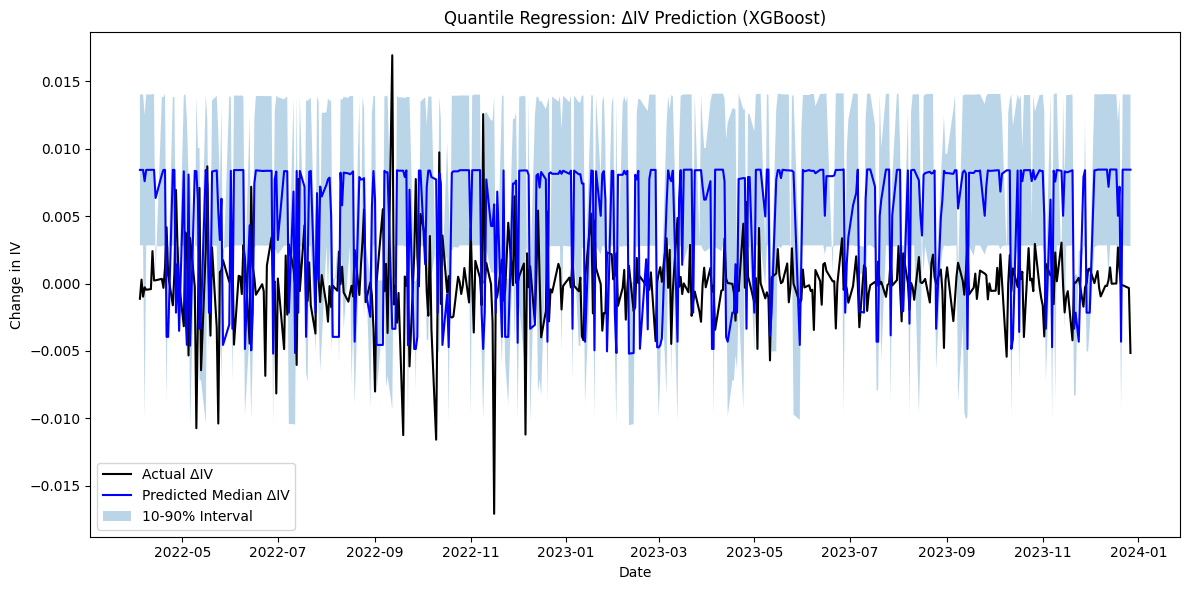


🔍 XGBoost Quantile Regression Evaluation:
MAE: 0.007313
MSE: 0.000065
R²:  -6.5655
Directional Accuracy: 42.43%


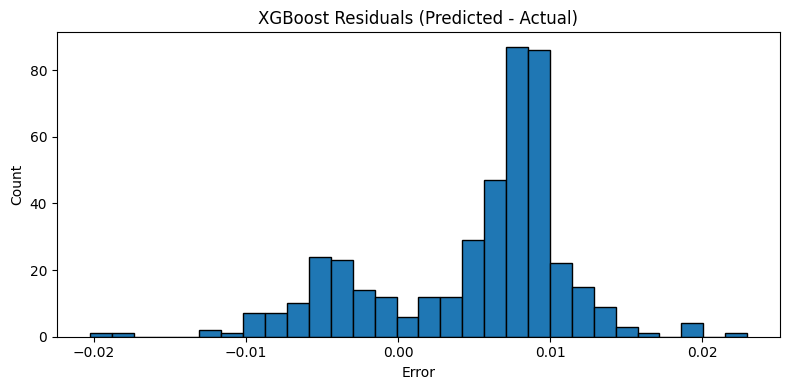

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step


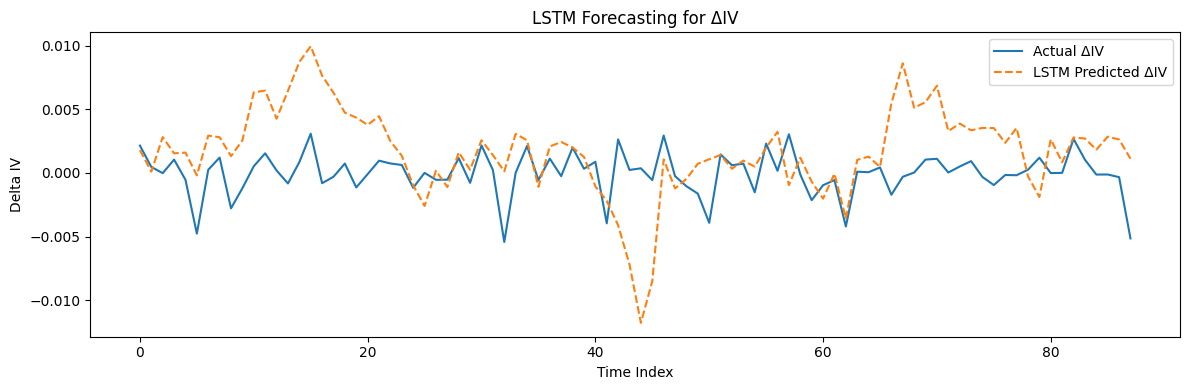


🧠 LSTM Forecast Evaluation:
MAE: 0.002948
MSE: 0.000015
R²:  -4.4223
Directional Accuracy: 59.09%

📏 Baseline (mean) MAE: 0.001144840506407174


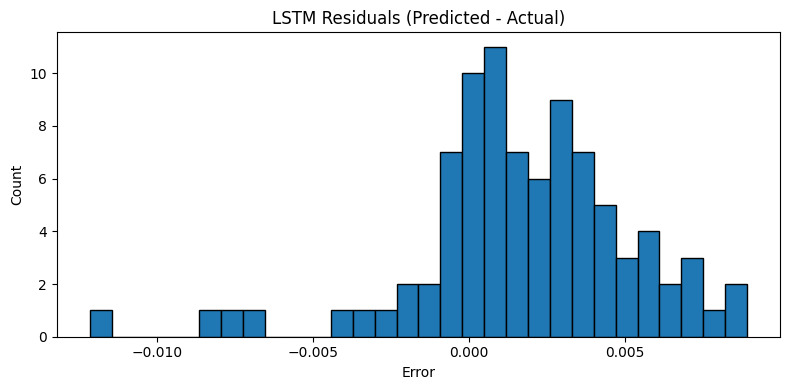

In [37]:
# Step-by-step execution:
df = load_data_with_advanced_features()
df = engineer_features(df)
df = add_prophet_features(df)

features = [
    'iv', 'dte', 'is_call', 'vix', 'trend', 'weekly', 'is_earnings_week',
    'iv_lag1', 'iv_lag2', 'delta_iv_lag1', 'delta_iv_lag2',
    'spy_return', 'spy_volume_change'
]
target = 'delta_iv'

# Run XGBoost
preds_q, actuals, dates = run_quantile_xgboost(df.copy(), features, target)
evaluate_and_plot_quantile(preds_q, actuals, dates)

# Run LSTM
run_lstm(df.copy(), features, target)


# 🧠 IV Delta Forecasting with XGBoost and LSTM

This notebook predicts the **daily change in implied volatility (ΔIV)** for SPY (S\&P 500 ETF) options using two distinct ML approaches:

* 🔺 **Quantile Regression with XGBoost**
* 🔁 **Sequential Forecasting with LSTM (Neural Network)**

## 📦 How It Works

### 1. **Data Collection**

* SPY (price, volume) and VIX (volatility index) are downloaded using `yfinance`.
* IV is approximated using 5-day rolling standard deviation of SPY returns.
* Target: **ΔIV = IV(t+1) - IV(t)**

### 2. **Feature Engineering**

* Market features: SPY returns, VIX, volume changes
* Option-style metadata: random DTE, call/put indicator
* Lagged IV/delta\_IV values
* Prophet-derived seasonal features (`trend`, `weekly`)

### 3. **Quantile XGBoost**

* Trains separate models for 10th, 50th, 90th percentiles
* Visualizes median forecast + confidence band (10–90%)
* Metrics: MAE, MSE, R², Directional Accuracy

### 4. **LSTM Model**

* Uses 60-day sequences of engineered features
* Predicts ΔIV using a simple 1-layer LSTM
* Evaluates performance and plots predictions + residuals

---

## 📈 Example Output

| Model   | MAE    | R²      | Directional Accuracy |
| ------- | ------ | ------- | -------------------- |
| XGBoost | 0.0073 | -6.5655 | 42.4%                |
| LSTM    | 0.0029 | -4.4223 | 59.1%                |

---

## 🛠 Requirements

Install dependencies using:

```bash
pip install yfinance prophet xgboost scikit-learn keras tensorflow
```

---

## ✅ Future Improvements

* Replace rolling IV with real implied volatility (from options chain)
* Use earnings calendar and macroeconomic events
* Test more advanced LSTM/Transformer architectures

---

Let me know if you’d like a version with images or Jupyter formatting.
